In [ ]:
#import gym_tetris
import gymnasium 
#import envpool

#from nes_py.wrappers import JoypadSpace
#from gym_tetris.actions import SIMPLE_MOVEMENT, MOVEMENT  # exists MOVEMENT, with more moves
import torch
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import pandas_ta as ta
import tensorflow as tf
from gymnasium.wrappers import FrameStack, GrayScaleObservation, AtariPreprocessing, FrameStack, ResizeObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, VecVideoRecorder, VecEnv, VecMonitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import PPO, DQN, TD3, DDPG, A2C
from stable_baselines3.ppo.policies import CnnPolicy, MultiInputPolicy, MlpPolicy
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.evaluation import evaluate_policy
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings


# Suppress the warning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import warnings

# Suppress the specific warning
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")


In [3]:
# Load financial data
ticker = '^GSPC'
start_date = dt.date.today() - dt.timedelta(days=365*10)  #years
end_date = dt.date.today() + dt.timedelta(days=1)
df = yf.download(ticker, start_date, end_date)

# energy sp500 sector
ticker_energy = '^GSPE'
start_date = dt.date.today() - dt.timedelta(days=365*10)  #years
end_date = dt.date.today() + dt.timedelta(days=1)
df_e = yf.download(ticker_energy, start_date, end_date)

# vix volatibility
ticker_vol = '^VIX'
start_date = dt.date.today() - dt.timedelta(days=365*10)  #years
end_date = dt.date.today() + dt.timedelta(days=1)
df_v = yf.download(ticker_vol, start_date, end_date)

# oil price
ticker_oil = 'CL=F'
start_date = dt.date.today() - dt.timedelta(days=365*10)  #años
end_date = dt.date.today() + dt.timedelta(days=1)
df_oil = yf.download(ticker_oil, start_date, end_date)

# 10 year treasury yield
ticker_dolar = 'DX-Y.NYB'
start_date = dt.date.today() - dt.timedelta(days=365*10)  #años
end_date = dt.date.today() + dt.timedelta(days=1)
df_dolar = yf.download(ticker_dolar, start_date, end_date)

# Gold
ticker_gold = 'GC=F'
start_date = dt.date.today() - dt.timedelta(days=365*10)  #años
end_date = dt.date.today() + dt.timedelta(days=1)
df_gold = yf.download(ticker_gold, start_date, end_date)

#BTC-EUR
ticker_btc = 'BTC-EUR'
start_date = dt.date.today() - dt.timedelta(days=365*10)  #años
end_date = dt.date.today() + dt.timedelta(days=1)
df_btc = yf.download(ticker_btc, start_date, end_date)

df_oil['feature_Oil_Close'] = df_oil['Close']
df_e['feature_E_Close'] = df_e['Close']
df_v['feature_Vol_Close'] = df_v['Close']
df_dolar['feature_Dolar_Close'] = df_dolar['Close']

# Adding the technical indicators
df['feature_RSI'] = ta.rsi(df['Close'], timeperiod=14)

df['feature_ATR'] = ta.atr(df['High'], df['Low'], df['Close'], timeperiod=14)
# Calculate stochastic oscillator
stoch_results = ta.stoch(df['High'], df['Low'], df['Close'], window=14, smooth_window=3)
df['feature_%K'] = stoch_results['STOCHk_14_3_3']
df['feature_%D'] = stoch_results['STOCHd_14_3_3']

# Add the MACD line to df
df_macd=df.ta.macd(fast=12, slow=26, signal=9, append=True)
# Add the MACD line to df
df['feature_MACD'] = df_macd['MACD_12_26_9']

# Calculate On-balance volume
df['feature_OBV']=ta.obv(df['Close'], df['Volume'])

#pct %
df["feature_PCT"] = df['Close'].pct_change()*100

df["close"] = df['Close']
df["feature_open"] = df['Open']
df["feature_high"] = df['High']
df["feature_low"] = df['Low']
df["feature_volume"] = df['Volume']



#### gold df #######
#pct %
df_gold["feature_PCT"] = df_gold['Close'].pct_change()*100
df_gold['feature_RSI'] = ta.rsi(df_gold['Close'], timeperiod=14)

df_gold["close"] = df_gold['Close']
df_gold["feature_open"] = df_gold['Open']
df_gold["feature_high"] = df_gold['High']
df_gold["feature_low"] = df_gold['Low']
df_gold["feature_volume"] = df_gold['Volume']

df_gold = pd.concat([df_gold,df_e['feature_E_Close'],df_v['feature_Vol_Close'],
                df_oil['feature_Oil_Close'],df_dolar['feature_Dolar_Close']], axis=1)
df_gold = df_gold.dropna()
features = ['feature_open', 'feature_high','feature_low', 'close','feature_volume', 
            'feature_RSI','feature_PCT','feature_E_Close','feature_Vol_Close',
            'feature_Oil_Close']

x_gold = df_gold[features]

###################################

#### BTC df #######
df_btc["feature_PCT"] = df_btc['Close'].pct_change()*100
df_btc['feature_RSI'] = ta.rsi(df_btc['Close'], timeperiod=14)

df_btc["close"] = df_btc['Close']
df_btc["feature_open"] = df_btc['Open']
df_btc["feature_high"] = df_btc['High']
df_btc["feature_low"] = df_btc['Low']
df_btc["feature_volume"] = df_btc['Volume']

df_btc = pd.concat([df_btc,df_e['feature_E_Close'],df_v['feature_Vol_Close'],
                df_oil['feature_Oil_Close'],df_dolar['feature_Dolar_Close']], axis=1)

df_btc = df_btc.dropna()
features = ['feature_open', 'feature_high','feature_low', 'close','feature_volume', 
            'feature_RSI','feature_PCT','feature_E_Close','feature_Vol_Close',
            'feature_Oil_Close']
x_btc = df_btc[features]

###################################

df = pd.concat([df,df_e['feature_E_Close'],df_v['feature_Vol_Close'],
               df_oil['feature_Oil_Close'],df_dolar['feature_Dolar_Close'],
               ], axis=1)

df = df.dropna()

# Extract features and signal features
# The environment will recognize as inputs every column that contains the 
# keyword ‘feature’ in its name.

#features = ['Open', 'High','Low', 'Volume', 'RSI','ATR','%K','%D','MACD_12_26_9','MACD','OBV']
#features = ['Open', 'High','Low', 'Volume', 'RSI', 'PCT']
#features = ['Open', 'High','Low', 'Volume', 'RSI','PCT','E_Close','Vol_Close','Oil_Close','Dolar_Close']
features = ['feature_open', 'feature_high','feature_low', 'close','feature_volume', 
            'feature_RSI','feature_PCT','feature_E_Close','feature_Vol_Close',
            'feature_Oil_Close']
#features = ['Open', 'High','Low', 'Volume', 'E_Close','Vol_Close','Oil_Close']
x = df[features]
y = df['Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
x

,feature_open,feature_high,feature_low,close,feature_volume,feature_RSI,feature_PCT,feature_E_Close,feature_Vol_Close,feature_Oil_Close
Date,,,,,,,,,,
2014-06-13,1930.800049,1937.300049,1927.689941,1936.160034,2.598230e+09,62.645715,0.313456,714.830017,12.180000,106.910004
2014-06-16,1934.839966,1941.150024,1930.910034,1937.780029,2.926130e+09,63.373397,0.083671,718.559998,12.650000,106.900002
2014-06-17,1937.150024,1943.689941,1933.550049,1941.989990,2.971260e+09,65.267017,0.217257,717.340027,12.060000,106.360001
2014-06-18,1942.729980,1957.739990,1939.290039,1956.979980,3.065220e+09,71.013475,0.771888,722.750000,10.610000,105.970001
2014-06-19,1957.500000,1959.869995,1952.260010,1959.479980,2.952150e+09,71.849965,0.127748,727.229980,10.620000,106.430000
...,...,...,...,...,...,...,...,...,...,...
2024-04-18,5031.520020,5056.660156,5001.890137,5011.120117,3.619760e+09,34.766746,-0.220816,717.950012,18.000000,82.730003
2024-04-19,5005.439941,5019.020020,4953.560059,4967.229980,3.878750e+09,31.291564,-0.875855,725.989990,18.709999,83.139999
2024-04-22,4987.330078,5038.839844,4969.399902,5010.600098,3.820250e+09,37.897454,0.873125,730.609985,16.940001,82.849998


In [ ]:
x.to_pickle("./x.pkl")  
x_gold.to_pickle("./x_gold.pkl")  

In [ ]:
import gym_trading_env


def reward_function_mod(history):
    rf = 0.002
    last = history["portfolio_valuation", -1]
    prev = history["portfolio_valuation", -2]
    rend = (last-prev)/prev
    return rend

def reward_function_sharp(history):
    rf = 0.002
    last = history["portfolio_valuation", :]
    prev = history["portfolio_valuation", 0]
    rend = (last-prev)/prev
    rend_risk = np.mean(rend)
    std = np.std(rend)
    if std != 0 :
        return rend_risk/std 
    else:
        return rend_risk



env = gymnasium.make("TradingEnv", df = x, 
#env = gymnasium.make("MultiDatasetTradingEnv", dataset_dir= './*.pkl',
#                     episodes_between_dataset_switch=5,
                     positions = [0, 0.25, 0.5, 0.75, 1], initial_position= 0, 
                     portfolio_initial_value=10000, windows = 1,
                     trading_fees = 0.024/100, # percent 
                     #reward_function = reward_function_mod,
                     render_mode='logs')

env.unwrapped.add_metric('Market Value', lambda history : 10e3*(history['data_close', -1]/history['data_close', 0]))
env.unwrapped.add_metric('Portfolio Value', lambda history : history["portfolio_valuation", -1])
env.unwrapped.add_metric('Diff.', lambda history : history["portfolio_valuation", -1] - 
                        10e3*(history['data_close', -1]/history['data_close', 0]))

In [ ]:
observation, info = env.reset()
observation.shape

In [ ]:
# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

In [7]:
#model = DQN("CnnPolicy", env, verbose=1, learning_rate=0.000001)
# learning_rate=lambda f: 2.4e-4*f, batch=4 


model = PPO("MlpPolicy",env, verbose=1, learning_rate=lambda f: 2.4e-4*f, n_steps=512, batch_size=512,
                    gamma=0.99, gae_lambda=0.95, clip_range=0.1)


#model = A2C("MlpPolicy",env, verbose=1, learning_rate=lambda f: 2.4e-4*f, n_steps=512,
#                    gamma=0.99, gae_lambda=0.95, use_rms_prop=False)


#model = RecurrentPPO("MlpLstmPolicy",env, verbose=1, learning_rate=lambda f: 2.4e-4*f, n_steps=512, batch_size=512, 
#                     gamma=0.99, gae_lambda=0.95, clip_range=0.1)


model.learn(total_timesteps= 1_000_000) #5_000_000)

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 2.48e+03      |
|    ep_rew_mean          | 0.933         |
| time/                   |               |
|    fps                  | 607           |
|    iterations           | 1928          |
|    time_elapsed         | 1625          |
|    total_timesteps      | 987136        |
| train/                  |               |
|    approx_kl            | 2.0954758e-09 |
|    clip_fraction        | 0             |
|    clip_range           | 0.1           |
|    entropy_loss         | -0.0148       |
|    explained_variance   | 0             |
|    learning_rate        | 3.21e-06      |
|    loss                 | 0.000484      |
|    n_updates            | 19270         |
|    policy_gradient_loss | -8.83e-07     |
|    value_loss           | 0.000973      |
-------------------------------------------
--------------------------------------
| rollout/                |          

In [8]:
env.unwrapped.get_metrics()

{'Market Return': '155.53%',
 'Portfolio Return': '152.38%',
 'Market Value': 25553.040259672813,
 'Portfolio Value': 25238.19703065783,
 'Diff.': -314.8432290149831}

In [9]:
hist = env.unwrapped.historical_info


values = hist['portfolio_valuation', :]
closes = hist['data_close', :]

print ("Market: ", 10e3*(closes[-1]/closes[0]))
print ("Agent: ", values[-1])

Market:  17088.15815179109
Agent:  16988.872456366444


In [ ]:
hist['data_close',-1]

In [10]:
positions = hist['position', :]
x_scatt = range(0,positions.shape[0])
x_scatt

range(0, 1412)

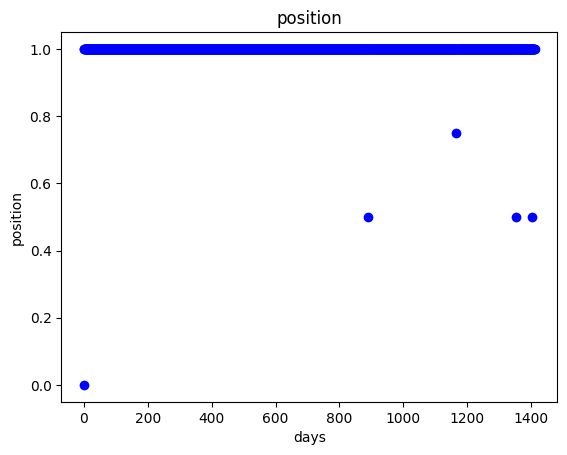

In [12]:
# POSITIONS

plt.scatter(x_scatt, positions, color='blue', label = 'position')
#plt.plot(x_scatt[2000:-1], positions[2000:-1], color='blue', label = 'position')
plt.title('position')
plt.xlabel('days')
plt.ylabel('position')
plt.show()

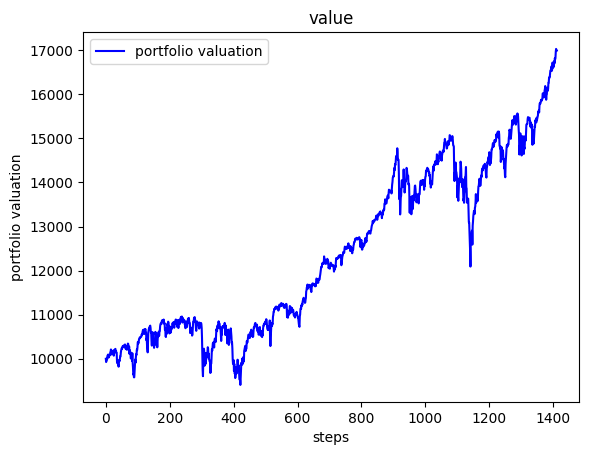

In [13]:
# PORTFOLIO VALUATION

plt.plot(values, color = 'blue', label = 'portfolio valuation')
#plt.plot(positions, color = 'red', label = 'SP500')
plt.title('value')
plt.xlabel('steps')
plt.ylabel('portfolio valuation')
plt.legend()
plt.show()

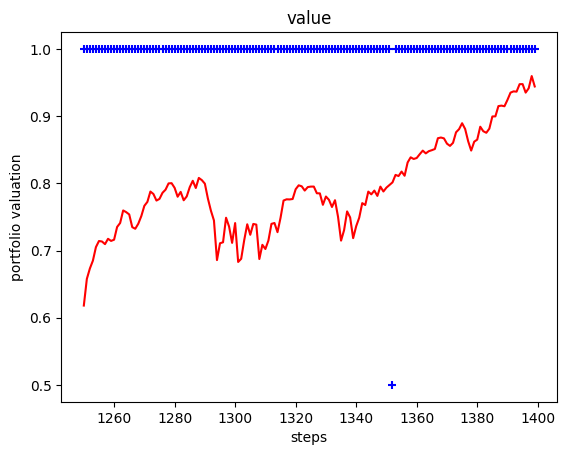

In [14]:
# PORTFOLIO/POSITIONS

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
values = values.reshape((values.shape[0],1))
values = scaler.fit_transform(values)

plt.plot(x_scatt[1250:1400], values[1250:1400], color = 'red', label = 'portfolio valuation')
plt.scatter(x_scatt[1250:1400], positions[1250:1400], color='blue', marker='+', label = 'position')
plt.title('value')
plt.xlabel('steps')
plt.ylabel('portfolio valuation')

plt.show()

In [ ]:
values.shape
positions.shape
x_scatt